# Visualising CANGRD Data for Canadian Climate Variables

Data available from CANGRD is in GeoTiff format and has to be interated with and opened by a python library called Rasterio. The CANGRD dataset uses Polar Stereographic Coordinates.

In [ ]:
conda install gdal --channel conda-forge

In [ ]:
conda install -c conda-forge poppler

In [37]:
conda install pandas

Retrieving notices: ...working... done
Channels:
 - defaults
 - conda-forge
Platform: osx-64
Solving environment: done

## Package Plan ##

  environment location: /opt/anaconda3

  added / updated specs:
    - pandas


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-24.9.2               |  py312hecd8cb5_0         1.1 MB
    ------------------------------------------------------------
                                           Total:         1.1 MB

The following packages will be SUPERSEDED by a higher-priority channel:

  certifi            conda-forge/noarch::certifi-2024.8.30~ --> pkgs/main/osx-64::certifi-2024.8.30-py312hecd8cb5_0 
  conda              conda-forge::conda-24.9.2-py312hb4010~ --> pkgs/main::conda-24.9.2-py312hecd8cb5_0 



                                                                                
Preparing transaction: done
Verifying transaction: done
Execu

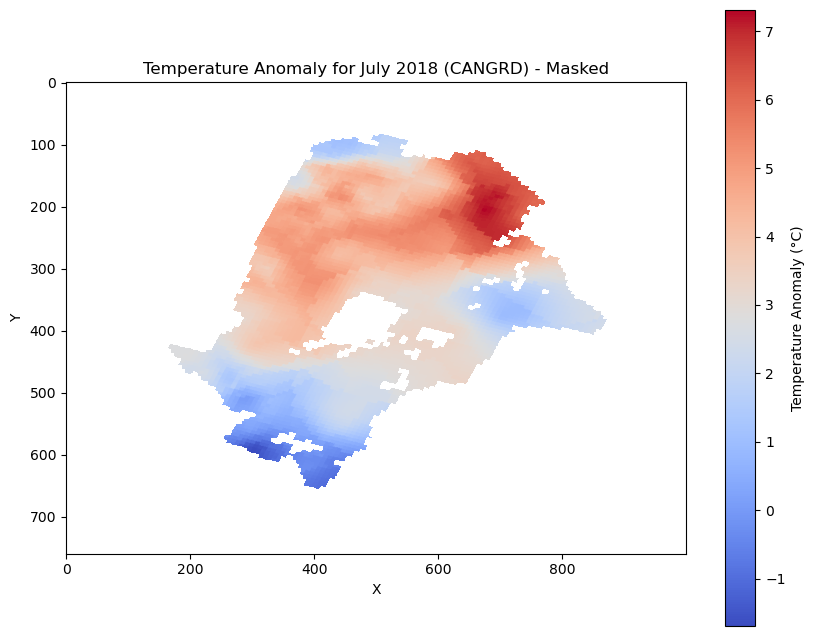

In [8]:
import rasterio
import rasterio.features
import rasterio.warp
import matplotlib.pyplot as plt
import numpy as np

with rasterio.open('/Users/maxMax/Desktop/Datasets/CANGRD_hist_monthly_anom_ps50km_TMEAN_2018-12.tif') as dataset: #importing dataset using rasterio
    
    temperature_data = dataset.read(1) #all data appears to be in first 'band'

    metadata = { #printing the metadata for debugging and plotting purposess
        'count': dataset.count,
        'width': dataset.width,
        'height': dataset.height,
        'bounds': dataset.bounds,
        'transform': dataset.transform,
        'crs': dataset.crs
    }

temperature_data_masked = np.ma.masked_where(temperature_data == 9999.9, temperature_data) #becaause the empty cell values here are given a value of 9999.9, they skew the values on the plot and make it impossible to differentiate variables on land therefore they are masked

plt.figure(figsize=(10, 8)) #plotting
plt.imshow(temperature_data_masked, cmap='coolwarm')
plt.colorbar(label="Temperature Anomaly (°C)")
plt.title("Temperature Anomaly for July 2018 (CANGRD) - Masked")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

Jupyter Notebook had isssues running the Rasterio library because it could not find the correct library in Poppler. It tries to find libpoppler.126.dylib when the only available is libpoppler.136.dylib. To fix this, open to console (terminal) and run the following command:

In [ ]:
ln -s /usr/local/lib/libpoppler.136.dylib /usr/local/lib/libpoppler.126.dylib

The documentation on CANGRD defines the coordinate system used ("The grid is a 125 (columns) by 95 (rows) matrix, where the SW corner (0,0) is at 40.05°N latitude and 129.85°W longitude. The projection is true at 60.0°N and centered on 110.0°W") which allowed me to transform the x and y axes into decimal coordinates (WSG84):

/var/folders/h5/wr1_5h5s2sd3jw2htzn509v00000gp/T/ipykernel_21088/2206628980.py:31: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lon, lat = transform(src_proj, dst_proj, x_proj_flat, y_proj_flat)#converting to WSG84 coordinates using pyproj
/var/folders/h5/wr1_5h5s2sd3jw2htzn509v00000gp/T/ipykernel_21088/2206628980.py:37: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(lon, lat, masked_data, cmap='coolwarm', shading='auto')


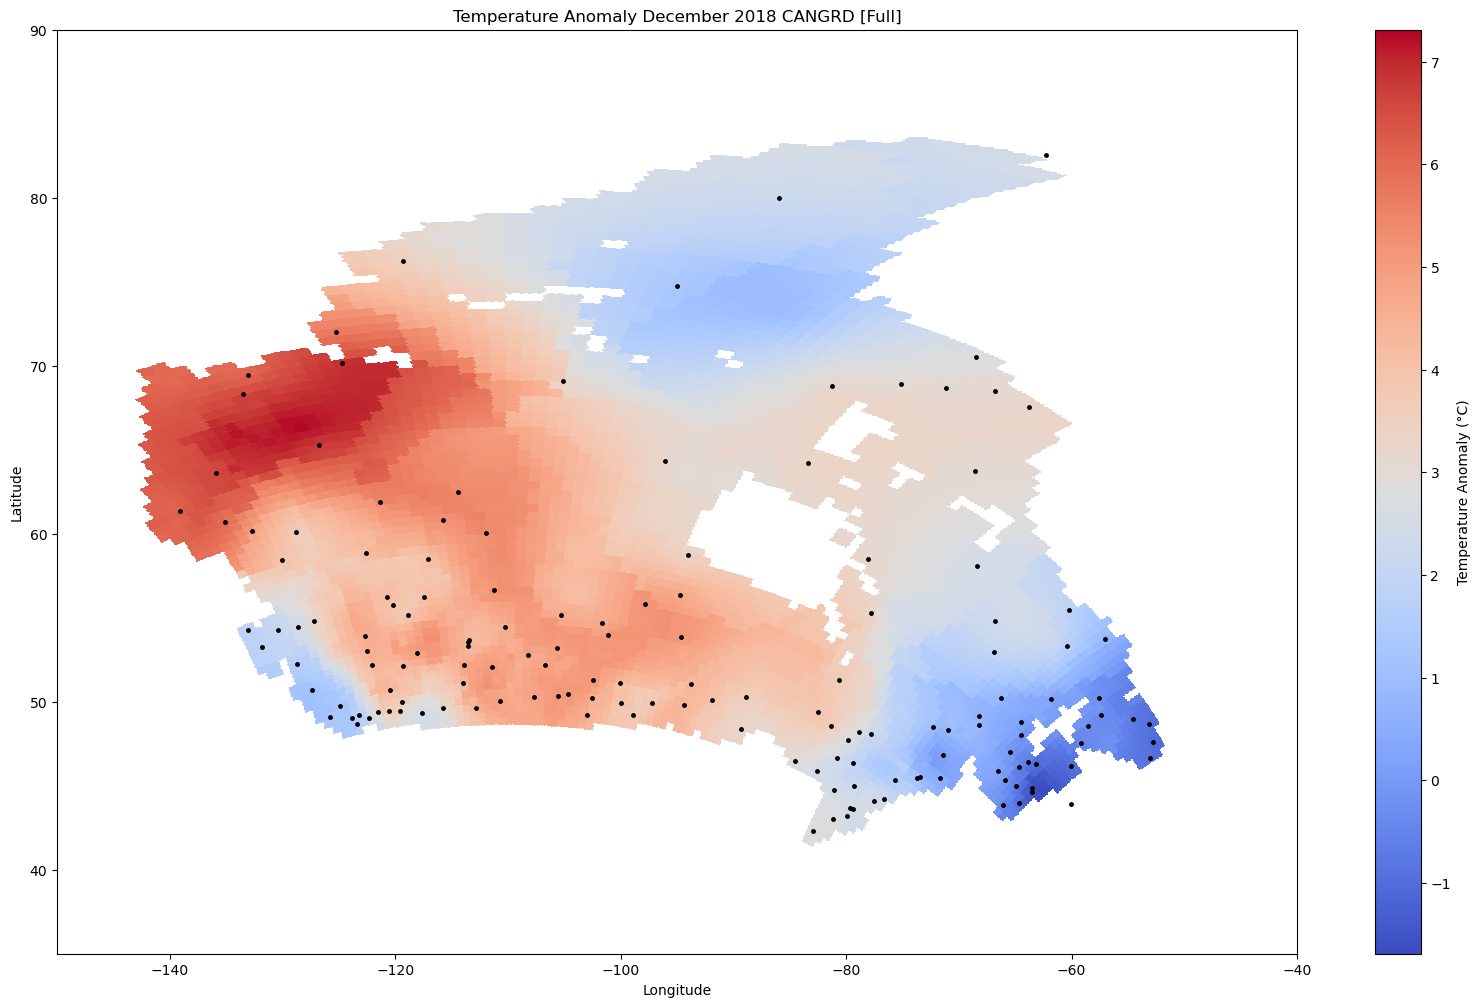

/var/folders/h5/wr1_5h5s2sd3jw2htzn509v00000gp/T/ipykernel_21088/2206628980.py:48: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(lon, lat, masked_data, cmap='coolwarm', shading='auto')


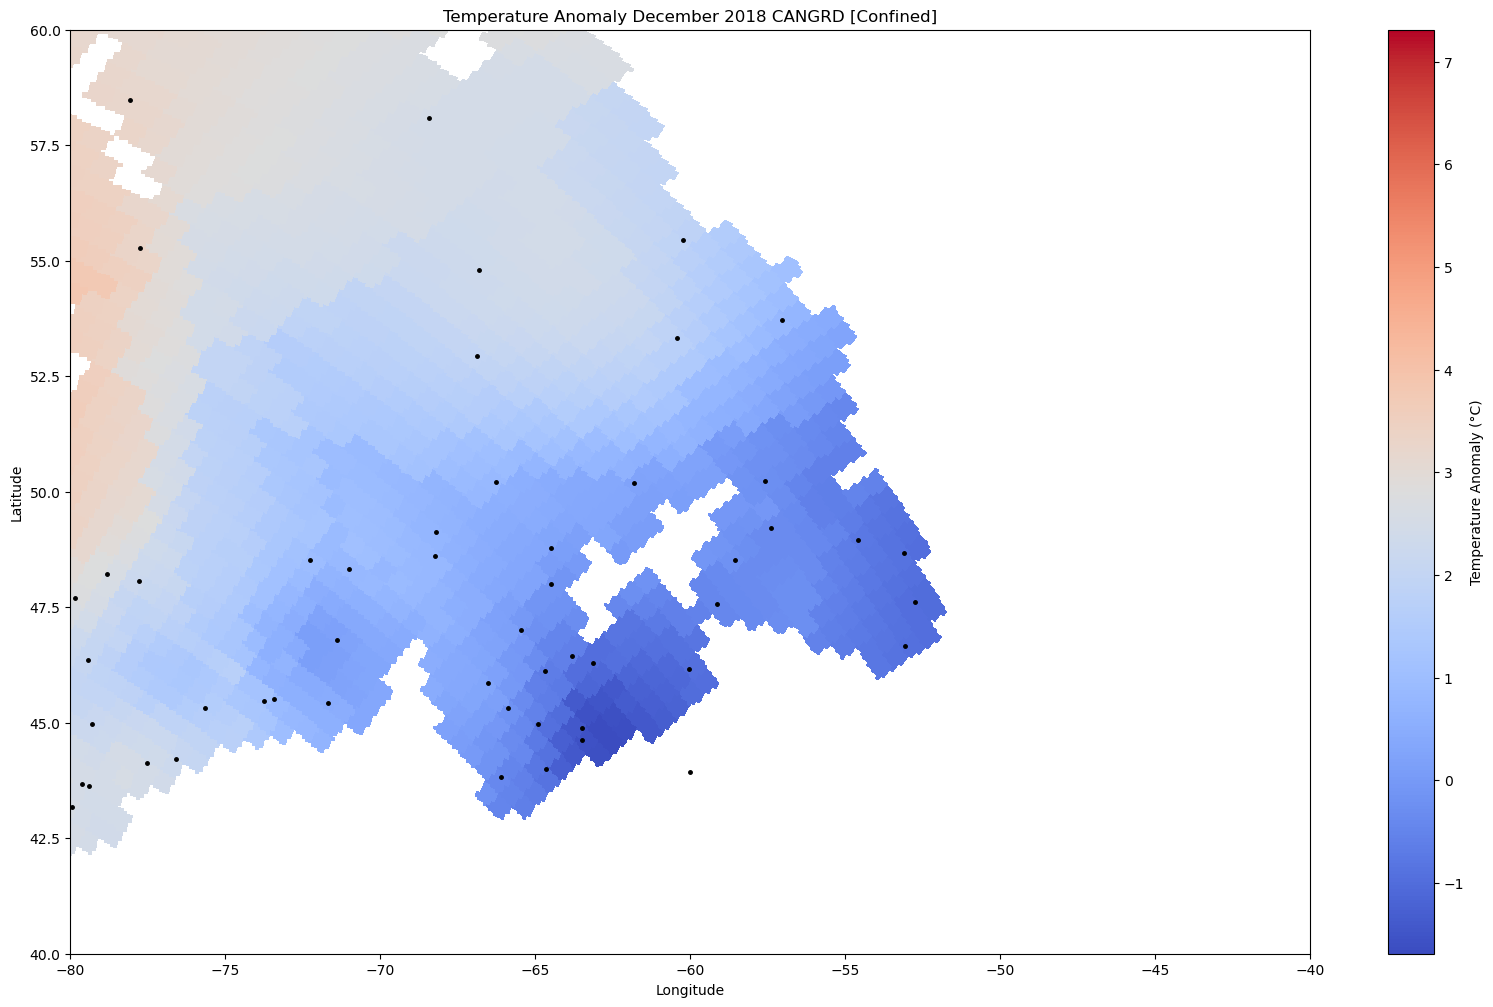

Number of stations in confined plot: 52
97                                  EARLTON A
101                               NORTH BAY A
103                                KINGSTON A
104          OTTAWA MACDONALD-CARTIER INT'L A
105                                 MUSKOKA A
109                                HAMILTON A
110                          TORONTO ISLAND A
111         TORONTO LESTER B. PEARSON INT'L A
112                                 TRENTON A
113                 QUEBEC/JEAN LESAGE INTL A
114    MONTREAL/PIERRE ELLIOTT TRUDEAU INTL A
115                      MONTREAL/ST-HUBERT A
116                              SHERBROOKE A
117                             BAIE-COMEAU A
118                              NATASHQUAN A
119                               SEPT-ILES A
120                                   GASPE A
121                               MONT-JOLI A
122                              BAGOTVILLE A
123                                ROBERVAL A
124                                   RO

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from pyproj import Proj, transform
import pandas as pd

wind_stations = pd.read_csv(r'/Users/maxMax/Desktop/Datasets/wind_stations1.csv')
ws_lat = wind_stations['lat (deg)'].values
ws_lon = wind_stations['long (deg)'].values

tif_path = r'/Users/maxMax/Desktop/Datasets/CANGRD_hist_monthly_anom_ps50km_TMEAN_2018-12.tif'
with rasterio.open(tif_path) as dataset:
    data = dataset.read(1)
    transform_matrix = dataset.transform #retrieves affinity transformation matrix (necessary for transforming coords)
    crs = dataset.crs #retrieves coord system used in dataset (polar stereographic)

masked_data = np.ma.masked_where(data == 9999.900000, data) #masking none vaalue data

src_proj = Proj(crs)  #source coordinate reference system (CRS)
dst_proj = Proj(proj='latlong', datum='WGS84')#defining target CRS as lat/long specifically WGS84 (decimal coordinates)

rows, cols = data.shape #retrieves the rows and columns from data as arrays
x_coords, y_coords = np.meshgrid(np.arange(cols), np.arange(rows))#creates a meshgrid to access the x and y coordinates

x_proj, y_proj = rasterio.transform.xy(transform_matrix, y_coords, x_coords)#converting pixel indices (x,y) into real coordinates using the affine transformation matrix

x_proj_flat = np.array(x_proj).flatten() #converting x/y_proj into 1D arrays because pyproj only works with 1D arrays
y_proj_flat = np.array(y_proj).flatten()

lon, lat = transform(src_proj, dst_proj, x_proj_flat, y_proj_flat)#converting to WSG84 coordinates using pyproj

lon = np.reshape(lon, x_coords.shape)#reshapes 1D arrys back into their original 2d grid shapes
lat = np.reshape(lat, y_coords.shape)

plt.figure(figsize=(20, 12))
plt.pcolormesh(lon, lat, masked_data, cmap='coolwarm', shading='auto')
plt.colorbar(label='Temperature Anomaly (°C)')
plt.ylim(35, 90)
plt.xlim(-150, -40)
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.scatter(ws_lon, ws_lat, color='black', s=25, marker='.') #showing location of Toronto
plt.title('Temperature Anomaly December 2018 CANGRD [Full]')
plt.show()

plt.figure(figsize=(20, 12))
plt.pcolormesh(lon, lat, masked_data, cmap='coolwarm', shading='auto')
plt.colorbar(label='Temperature Anomaly (°C)')
plt.ylim(40, 60)
plt.xlim(-80, -40)
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.scatter(ws_lon, ws_lat, color='black', s=25, marker='.') #showing locations of weather stations
plt.title('Temperature Anomaly December 2018 CANGRD [Confined]')
plt.show()\

lat_min, lat_max = 40, 60 #confined lats
lon_min, lon_max = -80, -40 #confined lons

confined_stations = wind_stations[ #filtering dataframe
    (wind_stations['lat (deg)'] >= lat_min) &
    (wind_stations['lat (deg)'] <= lat_max) &
    (wind_stations['long (deg)'] >= lon_min) &
    (wind_stations['long (deg)'] <= lon_max)
]

num_confined_stations = confined_stations.shape[0] #counting
print(f"Number of stations in confined plot: {num_confined_stations}")
print(confined_stations["station's name"], confined_stations['lat (deg)'], confined_stations['long (deg)'])


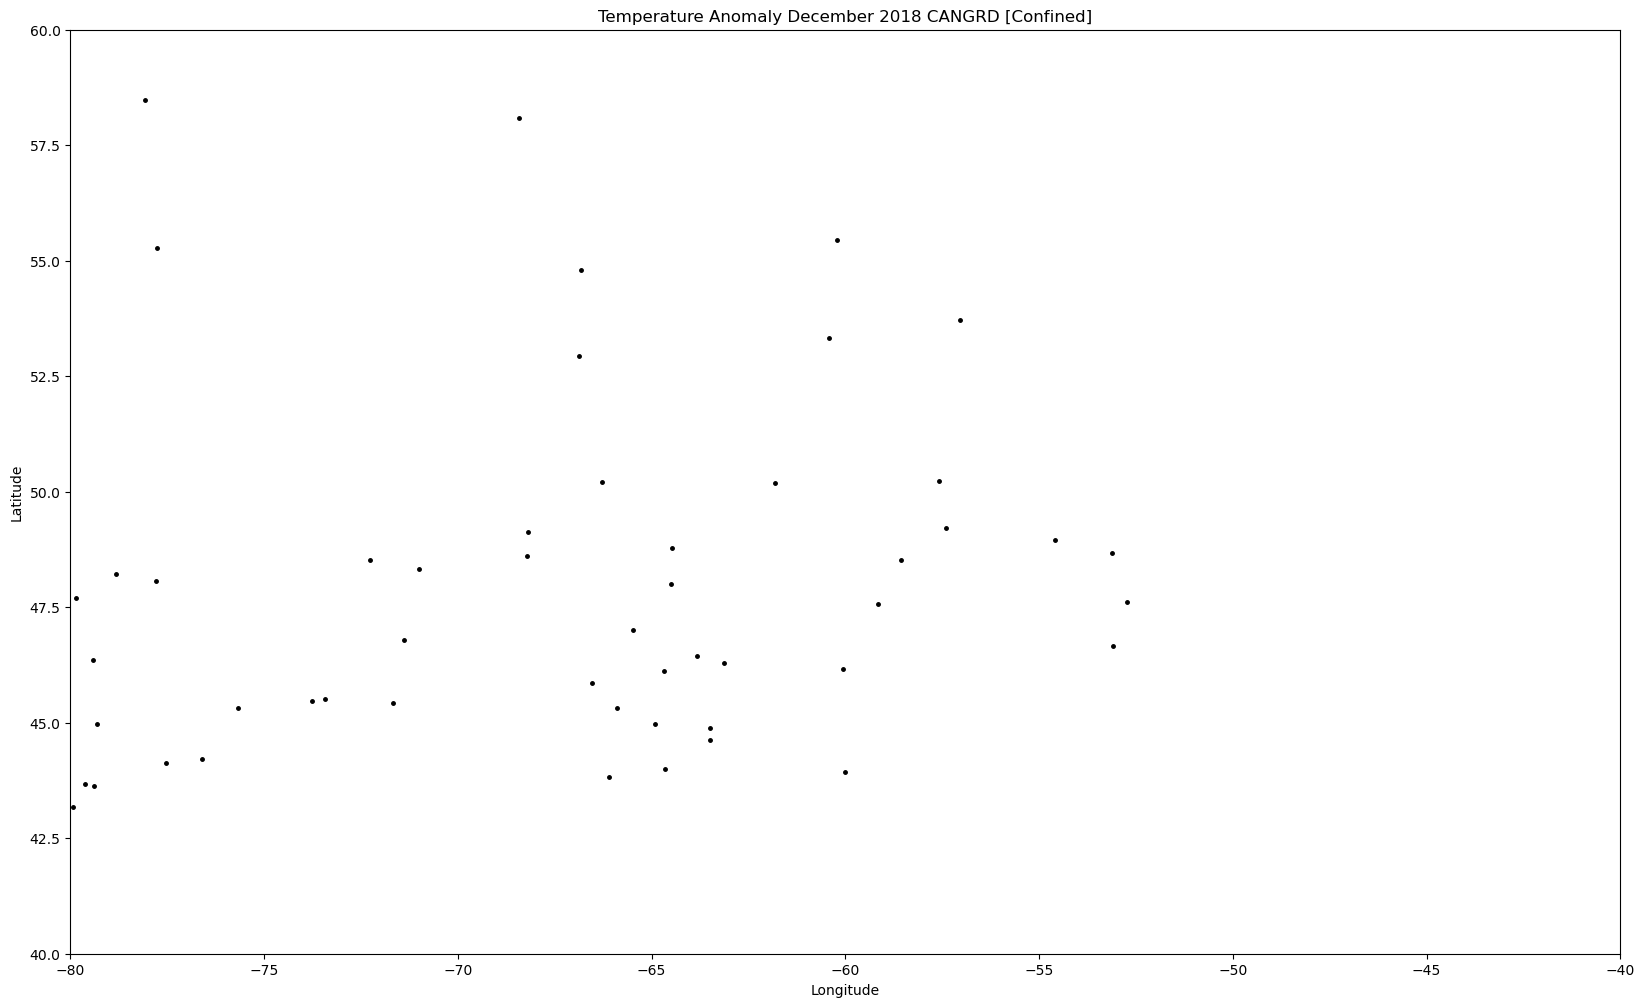

Number of stations in confined plot: 52
97                                  EARLTON A
101                               NORTH BAY A
103                                KINGSTON A
104          OTTAWA MACDONALD-CARTIER INT'L A
105                                 MUSKOKA A
109                                HAMILTON A
110                          TORONTO ISLAND A
111         TORONTO LESTER B. PEARSON INT'L A
112                                 TRENTON A
113                 QUEBEC/JEAN LESAGE INTL A
114    MONTREAL/PIERRE ELLIOTT TRUDEAU INTL A
115                      MONTREAL/ST-HUBERT A
116                              SHERBROOKE A
117                             BAIE-COMEAU A
118                              NATASHQUAN A
119                               SEPT-ILES A
120                                   GASPE A
121                               MONT-JOLI A
122                              BAGOTVILLE A
123                                ROBERVAL A
124                                   RO

In [8]:
plt.figure(figsize=(20, 12))
plt.ylim(40, 60)
plt.xlim(-80, -40)
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.scatter(ws_lon, ws_lat, color='black', s=25, marker='.') #showing locations of weather stations
plt.title('Temperature Anomaly December 2018 CANGRD [Confined]')
plt.show()\

lat_min, lat_max = 40, 60 #confined lats
lon_min, lon_max = -80, -40 #confined lons

confined_stations = wind_stations[ #filtering dataframe
    (wind_stations['lat (deg)'] >= lat_min) &
    (wind_stations['lat (deg)'] <= lat_max) &
    (wind_stations['long (deg)'] >= lon_min) &
    (wind_stations['long (deg)'] <= lon_max)
]

num_confined_stations = confined_stations.shape[0] #counting
print(f"Number of stations in confined plot: {num_confined_stations}")
print(confined_stations["station's name"], confined_stations['lat (deg)'], confined_stations['long (deg)'])


/var/folders/h5/wr1_5h5s2sd3jw2htzn509v00000gp/T/ipykernel_44174/335380746.py:8: DtypeWarning: Columns (10,12,19,24,27,29,34) have mixed types. Specify dtype option on import or set low_memory=False.
  ecws_data1 = pd.read_csv('/Users/maxMax/Desktop/Datasets/CANADA/climate-daily (4).csv')
/var/folders/h5/wr1_5h5s2sd3jw2htzn509v00000gp/T/ipykernel_44174/335380746.py:9: DtypeWarning: Columns (5,9,22,23,32) have mixed types. Specify dtype option on import or set low_memory=False.
  ecws_data2 = pd.read_csv('/Users/maxMax/Desktop/Datasets/CANADA/climate-daily (5).csv')
/var/folders/h5/wr1_5h5s2sd3jw2htzn509v00000gp/T/ipykernel_44174/335380746.py:10: DtypeWarning: Columns (3,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  ecws_data3 = pd.read_csv('/Users/maxMax/Desktop/Datasets/CANADA/climate-daily (9).csv')
/var/folders/h5/wr1_5h5s2sd3jw2htzn509v00000gp/T/ipykernel_44174/335380746.py:11: DtypeWarning: Columns (26,31) have mixed types. Specify dtype option

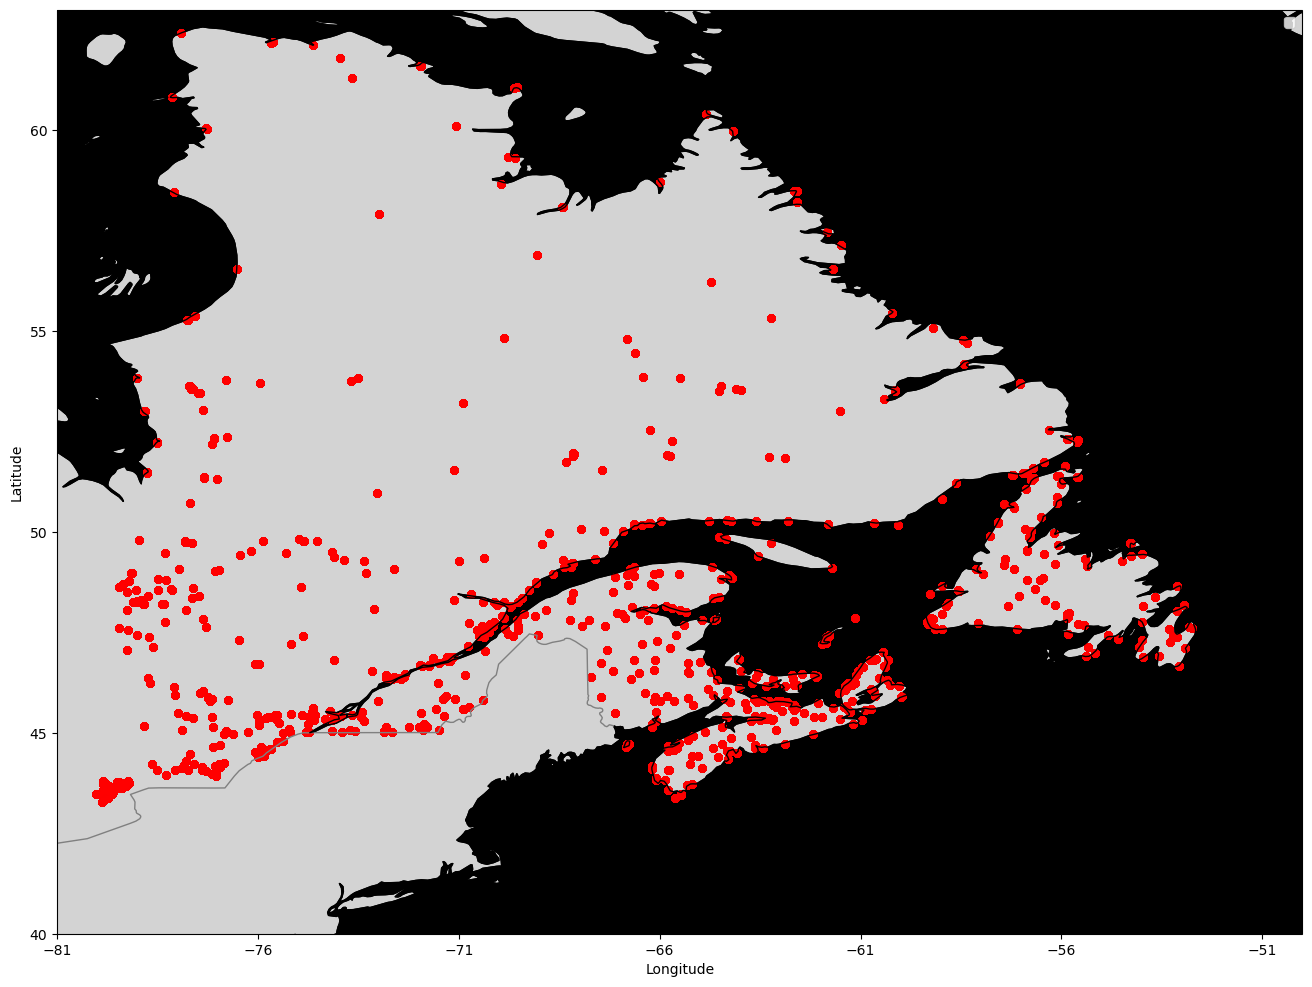

In [10]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import numpy as np

ecws_data1 = pd.read_csv('/Users/maxMax/Desktop/Datasets/CANADA/climate-daily (4).csv')
ecws_data2 = pd.read_csv('/Users/maxMax/Desktop/Datasets/CANADA/climate-daily (5).csv')
ecws_data3 = pd.read_csv('/Users/maxMax/Desktop/Datasets/CANADA/climate-daily (9).csv')
ecws_data4 = pd.read_csv('/Users/maxMax/Desktop/Datasets/CANADA/climate-daily (10).csv')
ecws_data5 = pd.read_csv('/Users/maxMax/Desktop/Datasets/CANADA/climate-daily (11).csv')
ecws_data6 = pd.read_csv('/Users/maxMax/Desktop/Datasets/CANADA/climate-daily (12).csv')
ecws_data7 = pd.read_csv('/Users/maxMax/Desktop/Datasets/CANADA/climate-daily (13).csv')
ecws_data8 = pd.read_csv('/Users/maxMax/Desktop/Datasets/CANADA/climate-daily (14).csv')
ecws_data9 = pd.read_csv('/Users/maxMax/Desktop/Datasets/CANADA/climate-daily (15).csv')
ecws_data10 = pd.read_csv('/Users/maxMax/Desktop/Datasets/CANADA/climate-daily (16).csv')
ecws_data11 = pd.read_csv('/Users/maxMax/Desktop/Datasets/CANADA/climate-daily (17).csv')
ecws_data12 = pd.read_csv('/Users/maxMax/Desktop/Datasets/CANADA/climate-daily (18).csv')
ecws_data13 = pd.read_csv('/Users/maxMax/Desktop/Datasets/CANADA/climate-daily (19).csv')
ecws_data14 = pd.read_csv('/Users/maxMax/Desktop/Datasets/CANADA/climate-daily (20).csv')
ecws_data15 = pd.read_csv('/Users/maxMax/Desktop/Datasets/CANADA/climate-daily (21).csv')
ecws_data16 = pd.read_csv('/Users/maxMax/Desktop/Datasets/CANADA/climate-daily (22).csv')
ecws_data17 = pd.read_csv('/Users/maxMax/Desktop/Datasets/CANADA/climate-daily (23).csv')
ecws_data18 = pd.read_csv('/Users/maxMax/Desktop/Datasets/CANADA/climate-daily (24).csv')
ecws_data19 = pd.read_csv('/Users/maxMax/Desktop/Datasets/CANADA/climate-daily (25).csv')
ecws_data20 = pd.read_csv('/Users/maxMax/Desktop/Datasets/CANADA/climate-daily (26).csv')
ecws_data21 = pd.read_csv('/Users/maxMax/Desktop/Datasets/CANADA/climate-daily (27).csv')
ecws_data22 = pd.read_csv('/Users/maxMax/Desktop/Datasets/CANADA/climate-daily (28).csv')
ecws_data23 = pd.read_csv('/Users/maxMax/Desktop/Datasets/CANADA/climate-daily (29).csv')
ecws_data24 = pd.read_csv('/Users/maxMax/Desktop/Datasets/CANADA/climate-daily (30).csv')
ecws_data25 = pd.read_csv('/Users/maxMax/Desktop/Datasets/CANADA/climate-daily (31).csv')
ecws_data26 = pd.read_csv('/Users/maxMax/Desktop/Datasets/CANADA/climate-daily (32).csv')
ecws_data27 = pd.read_csv('/Users/maxMax/Desktop/Datasets/CANADA/climate-daily (33).csv')
ecws_data28 = pd.read_csv('/Users/maxMax/Desktop/Datasets/CANADA/climate-daily (34).csv')
ecws_data29 = pd.read_csv('/Users/maxMax/Desktop/Datasets/CANADA/climate-daily (35).csv')
ecws_data30 = pd.read_csv('/Users/maxMax/Desktop/Datasets/CANADA/climate-daily (36).csv')
ecws_data31 = pd.read_csv('/Users/maxMax/Desktop/Datasets/CANADA/climate-daily (37).csv')
ecws_data32 = pd.read_csv('/Users/maxMax/Desktop/Datasets/CANADA/climate-daily (38).csv')
ecws_data33 = pd.read_csv('/Users/maxMax/Desktop/Datasets/CANADA/climate-daily (39).csv')
ecws_data34 = pd.read_csv('/Users/maxMax/Desktop/Datasets/CANADA/climate-daily (40).csv')
ecws_data35 = pd.read_csv('/Users/maxMax/Desktop/Datasets/CANADA/climate-daily (41).csv')
ecws_data36 = pd.read_csv('/Users/maxMax/Desktop/Datasets/CANADA/climate-daily (42).csv')
ecws_data37 = pd.read_csv('/Users/maxMax/Desktop/Datasets/CANADA/climate-daily (43).csv')
ecws_data38 = pd.read_csv('/Users/maxMax/Desktop/Datasets/CANADA/climate-daily (44).csv')
ecws_data39 = pd.read_csv('/Users/maxMax/Desktop/Datasets/CANADA/climate-daily (45).csv')
ecws_data40 = pd.read_csv('/Users/maxMax/Desktop/Datasets/CANADA/climate-daily (46).csv')
ecws_data41 = pd.read_csv('/Users/maxMax/Desktop/Datasets/CANADA/climate-daily (47).csv')
ecws_data42 = pd.read_csv('/Users/maxMax/Desktop/Datasets/CANADA/climate-daily (48).csv')
ecws_data43 = pd.read_csv('/Users/maxMax/Desktop/Datasets/CANADA/climate-daily (49).csv')
ecws_data44 = pd.read_csv('/Users/maxMax/Desktop/Datasets/CANADA/climate-daily (50).csv')
ecws_data45 = pd.read_csv('/Users/maxMax/Desktop/Datasets/CANADA/CanadianStations.csv')


#extracting longitude and latitude
ecws_lon1 = ecws_data1['x']
ecws_lat1 = ecws_data1['y']

ecws_lon2 = ecws_data2['x']
ecws_lat2 = ecws_data2['y']

ecws_lon3 = ecws_data3['x']
ecws_lat3 = ecws_data3['y']

ecws_lon4 = ecws_data4['x']
ecws_lat4 = ecws_data4['y']

ecws_lon5 = ecws_data5['x']
ecws_lat5 = ecws_data5['y']

ecws_lon6 = ecws_data6['x']
ecws_lat6 = ecws_data6['y']

ecws_lon7 = ecws_data7['x']
ecws_lat7 = ecws_data7['y']

ecws_lon8 = ecws_data8['x']
ecws_lat8 = ecws_data8['y']

ecws_lon9 = ecws_data9['x']
ecws_lat9 = ecws_data9['y']

ecws_lon10 = ecws_data10['x']
ecws_lat10 = ecws_data10['y']

ecws_lon11 = ecws_data11['x']
ecws_lat11 = ecws_data11['y']

ecws_lon12 = ecws_data12['x']
ecws_lat12 = ecws_data12['y']

ecws_lon13 = ecws_data13['x']
ecws_lat13 = ecws_data13['y']

ecws_lon14 = ecws_data14['x']
ecws_lat14 = ecws_data14['y']

ecws_lon15 = ecws_data15['x']
ecws_lat15 = ecws_data15['y']

ecws_lon16 = ecws_data16['x']
ecws_lat16 = ecws_data16['y']

ecws_lon17 = ecws_data17['x']
ecws_lat17 = ecws_data17['y']

ecws_lon18 = ecws_data18['x']
ecws_lat18 = ecws_data18['y']

ecws_lon19 = ecws_data19['x']
ecws_lat19 = ecws_data19['y']

ecws_lon20 = ecws_data20['x']
ecws_lat20 = ecws_data20['y']

ecws_lon21 = ecws_data21['x']
ecws_lat21 = ecws_data21['y']

ecws_lon22 = ecws_data22['x']
ecws_lat22 = ecws_data22['y']

ecws_lon23 = ecws_data23['x']
ecws_lat23 = ecws_data23['y']

ecws_lon24 = ecws_data24['x']
ecws_lat24 = ecws_data24['y']

ecws_lon25 = ecws_data25['x']
ecws_lat25 = ecws_data25['y']

ecws_lon26 = ecws_data26['x']
ecws_lat26 = ecws_data26['y']

ecws_lon27 = ecws_data27['x']
ecws_lat27 = ecws_data27['y']

ecws_lon28 = ecws_data28['x']
ecws_lat28 = ecws_data28['y']

ecws_lon29 = ecws_data29['x']
ecws_lat29 = ecws_data29['y']

ecws_lon30 = ecws_data30['x']
ecws_lat30 = ecws_data30['y']

ecws_lon31 = ecws_data31['x']
ecws_lat31 = ecws_data31['y']

ecws_lon32 = ecws_data32['x']
ecws_lat32 = ecws_data32['y']

ecws_lon33 = ecws_data33['x']
ecws_lat33 = ecws_data33['y']

ecws_lon34 = ecws_data34['x']
ecws_lat34 = ecws_data34['y']

ecws_lon35 = ecws_data35['x']
ecws_lat35 = ecws_data35['y']

ecws_lon36 = ecws_data36['x']
ecws_lat36 = ecws_data36['y']

ecws_lon37 = ecws_data37['x']
ecws_lat37 = ecws_data37['y']

ecws_lon38 = ecws_data38['x']
ecws_lat38 = ecws_data38['y']

ecws_lon39 = ecws_data39['x']
ecws_lat39 = ecws_data39['y']

ecws_lon40 = ecws_data40['x']
ecws_lat40 = ecws_data40['y']

ecws_lon41 = ecws_data41['x']
ecws_lat41 = ecws_data41['y']

ecws_lon42 = ecws_data42['x']
ecws_lat42 = ecws_data42['y']

ecws_lon43 = ecws_data43['x']
ecws_lat43 = ecws_data43['y']

ecws_lon44 = ecws_data44['x']
ecws_lat44 = ecws_data44['y']

ecws_lon45 = ecws_data45['x']
ecws_lat45 = ecws_data45['y']


lat_min, lat_max = 40, 63 #set map boundaries
lon_min, lon_max = -81, -50

fig, ax =plt.subplots(figsize=(20, 12), subplot_kw={'projection': ccrs.PlateCarree()}) #seting figure and cartopy projection
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='gray') #adding map features
ax.add_feature(cfeature.COASTLINE, edgecolor='black')
ax.add_feature(cfeature.LAND, color='lightgrey')
ax.add_feature(cfeature.OCEAN, color='black')
ax.set_xticks(np.arange(lon_min, lon_max + 1, 5), crs=ccrs.PlateCarree())#longitude ticks every 5
ax.set_yticks(np.arange(lat_min, lat_max + 1, 5), crs=ccrs.PlateCarree())#latitude ticks every 5

plt.scatter(ecws_lon1, ecws_lat1, color='red', s=25, marker='o', transform=ccrs.PlateCarree()) #plotting ANUSPLIN data stations
plt.scatter(ecws_lon2, ecws_lat2, color='red', s=25, marker='o', transform=ccrs.PlateCarree())
plt.scatter(ecws_lon3, ecws_lat3, color='red', s=25, marker='o', transform=ccrs.PlateCarree())
plt.scatter(ecws_lon4, ecws_lat4, color='red', s=25, marker='o', transform=ccrs.PlateCarree())
plt.scatter(ecws_lon5, ecws_lat5, color='red', s=25, marker='o', transform=ccrs.PlateCarree())
plt.scatter(ecws_lon6, ecws_lat6, color='red', s=25, marker='o', transform=ccrs.PlateCarree())
plt.scatter(ecws_lon7, ecws_lat7, color='red', s=25, marker='o', transform=ccrs.PlateCarree())
plt.scatter(ecws_lon8, ecws_lat8, color='red', s=25, marker='o', transform=ccrs.PlateCarree())
plt.scatter(ecws_lon9, ecws_lat9, color='red', s=25, marker='o', transform=ccrs.PlateCarree())
plt.scatter(ecws_lon10, ecws_lat10, color='red', s=25, marker='o', transform=ccrs.PlateCarree())
plt.scatter(ecws_lon11, ecws_lat11, color='red', s=25, marker='o', transform=ccrs.PlateCarree())
plt.scatter(ecws_lon12, ecws_lat12, color='red', s=25, marker='o', transform=ccrs.PlateCarree())
plt.scatter(ecws_lon13, ecws_lat13, color='red', s=25, marker='o', transform=ccrs.PlateCarree())
plt.scatter(ecws_lon14, ecws_lat14, color='red', s=25, marker='o', transform=ccrs.PlateCarree())
plt.scatter(ecws_lon15, ecws_lat15, color='red', s=25, marker='o', transform=ccrs.PlateCarree())
plt.scatter(ecws_lon16, ecws_lat16, color='red', s=25, marker='o', transform=ccrs.PlateCarree())
plt.scatter(ecws_lon17, ecws_lat17, color='red', s=25, marker='o', transform=ccrs.PlateCarree())
plt.scatter(ecws_lon18, ecws_lat18, color='red', s=25, marker='o', transform=ccrs.PlateCarree())
plt.scatter(ecws_lon19, ecws_lat19, color='red', s=25, marker='o', transform=ccrs.PlateCarree())
plt.scatter(ecws_lon20, ecws_lat20, color='red', s=25, marker='o', transform=ccrs.PlateCarree())
plt.scatter(ecws_lon21, ecws_lat21, color='red', s=25, marker='o', transform=ccrs.PlateCarree())
plt.scatter(ecws_lon22, ecws_lat22, color='red', s=25, marker='o', transform=ccrs.PlateCarree())
plt.scatter(ecws_lon23, ecws_lat23, color='red', s=25, marker='o', transform=ccrs.PlateCarree())
plt.scatter(ecws_lon24, ecws_lat24, color='red', s=25, marker='o', transform=ccrs.PlateCarree())
plt.scatter(ecws_lon25, ecws_lat25, color='red', s=25, marker='o', transform=ccrs.PlateCarree())
plt.scatter(ecws_lon26, ecws_lat26, color='red', s=25, marker='o', transform=ccrs.PlateCarree())
plt.scatter(ecws_lon27, ecws_lat27, color='red', s=25, marker='o', transform=ccrs.PlateCarree())
plt.scatter(ecws_lon28, ecws_lat28, color='red', s=25, marker='o', transform=ccrs.PlateCarree())
plt.scatter(ecws_lon29, ecws_lat29, color='red', s=25, marker='o', transform=ccrs.PlateCarree())
plt.scatter(ecws_lon30, ecws_lat30, color='red', s=25, marker='o', transform=ccrs.PlateCarree())
plt.scatter(ecws_lon31, ecws_lat31, color='red', s=25, marker='o', transform=ccrs.PlateCarree())
plt.scatter(ecws_lon32, ecws_lat32, color='red', s=25, marker='o', transform=ccrs.PlateCarree())
plt.scatter(ecws_lon33, ecws_lat33, color='red', s=25, marker='o', transform=ccrs.PlateCarree())
plt.scatter(ecws_lon34, ecws_lat34, color='red', s=25, marker='o', transform=ccrs.PlateCarree())
plt.scatter(ecws_lon35, ecws_lat35, color='red', s=25, marker='o', transform=ccrs.PlateCarree())
plt.scatter(ecws_lon36, ecws_lat36, color='red', s=25, marker='o', transform=ccrs.PlateCarree())
plt.scatter(ecws_lon37, ecws_lat37, color='red', s=25, marker='o', transform=ccrs.PlateCarree())
plt.scatter(ecws_lon38, ecws_lat38, color='red', s=25, marker='o', transform=ccrs.PlateCarree())
plt.scatter(ecws_lon39, ecws_lat39, color='red', s=25, marker='o', transform=ccrs.PlateCarree())
plt.scatter(ecws_lon40, ecws_lat40, color='red', s=25, marker='o', transform=ccrs.PlateCarree())
plt.scatter(ecws_lon41, ecws_lat41, color='red', s=25, marker='o', transform=ccrs.PlateCarree())
plt.scatter(ecws_lon42, ecws_lat42, color='red', s=25, marker='o', transform=ccrs.PlateCarree())
plt.scatter(ecws_lon43, ecws_lat43, color='red', s=25, marker='o', transform=ccrs.PlateCarree())
plt.scatter(ecws_lon44, ecws_lat44, color='red', s=25, marker='o', transform=ccrs.PlateCarree())
plt.scatter(ecws_lon45, ecws_lat45, color='red', s=25, marker='o', transform=ccrs.PlateCarree())

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()


In [11]:
import pandas as pd
import glob
import numpy as np

path = '/Users/maxMax/Desktop/Datasets/CANADA/*.csv'
all_files = glob.glob(path) #using glob to get all csv file paths
combined_df = pd.concat((pd.read_csv(file) for file in all_files), ignore_index=True)#read and concatenate all csv files, and ignore repeated headers
combined_df.to_csv("CanadianStations.csv", index=False) #saves to single csv


/var/folders/h5/wr1_5h5s2sd3jw2htzn509v00000gp/T/ipykernel_44174/2445069829.py:7: DtypeWarning: Columns (5,19,26,28,29,31) have mixed types. Specify dtype option on import or set low_memory=False.
  combined_df = pd.concat((pd.read_csv(file) for file in all_files), ignore_index=True)#read and concatenate all csv files, and ignore repeated headers
/var/folders/h5/wr1_5h5s2sd3jw2htzn509v00000gp/T/ipykernel_44174/2445069829.py:7: DtypeWarning: Columns (11,15,16,23,27) have mixed types. Specify dtype option on import or set low_memory=False.
  combined_df = pd.concat((pd.read_csv(file) for file in all_files), ignore_index=True)#read and concatenate all csv files, and ignore repeated headers
/var/folders/h5/wr1_5h5s2sd3jw2htzn509v00000gp/T/ipykernel_44174/2445069829.py:7: DtypeWarning: Columns (2,3,16,18,20,23,25,27,28,32,34) have mixed types. Specify dtype option on import or set low_memory=False.
  combined_df = pd.concat((pd.read_csv(file) for file in all_files), ignore_index=True)#read 

In [38]:
import pandas as pd
import numpy as np

data = pd.read_csv('/Users/maxMax/Desktop/Datasets/CANADA/CanadianStations.csv')
data.replace("", np.nan, inplace=True)#replace empty values with NaN

data['LOCAL_DATE'] = pd.to_datetime(data['LOCAL_DATE'])#converting local date values to pandas datetime object
data['year'] = data['LOCAL_DATE'].dt.year
data['month'] = data['LOCAL_DATE'].dt.month

monthly_avg = data.groupby(['x', 'y', 'STATION_NAME', 'year', 'month']).agg({#computes monthly mean averages
    'MIN_TEMPERATURE': 'mean',
    'MAX_TEMPERATURE': 'mean',
    'MEAN_TEMPERATURE': 'mean',
    'TOTAL_PRECIPITATION': 'mean',
    'TOTAL_RAIN': 'mean',
    'TOTAL_SNOW': 'mean',
    'MIN_REL_HUMIDITY': 'mean',
    'MAX_REL_HUMIDITY': 'mean',
    'SNOW_ON_GROUND': 'mean',
    'SPEED_MAX_GUST': 'mean',
    'DIRECTION_MAX_GUST': 'mean',
}).reset_index()
monthly_avg['average_type'] = 'monthly'

valid_years = data.groupby(['x', 'y', 'STATION_NAME', 'year']).month.nunique().reset_index()#filtering annual data to only include years with 12 months of data
valid_years = valid_years[valid_years['month'] == 12]

data_filtered = data.merge(valid_years[['x', 'y', 'STATION_NAME', 'year']], on=['x', 'y', 'STATION_NAME', 'year'])#merging to only include these years in the averages

yearly_avg = data_filtered.groupby(['x', 'y', 'STATION_NAME', 'year']).agg({#computes yearly mean averages
    'MIN_TEMPERATURE': 'mean',
    'MAX_TEMPERATURE': 'mean',
    'MEAN_TEMPERATURE': 'mean',
    'TOTAL_PRECIPITATION': 'mean',
    'TOTAL_RAIN': 'mean',
    'TOTAL_SNOW': 'mean',
    'MIN_REL_HUMIDITY': 'mean',
    'MAX_REL_HUMIDITY': 'mean',
    'SNOW_ON_GROUND': 'mean',
    'SPEED_MAX_GUST': 'mean',
    'DIRECTION_MAX_GUST': 'mean',
}).reset_index()
yearly_avg['month'] = None
yearly_avg['average_type'] = 'yearly'

combined_avg = pd.concat([monthly_avg, yearly_avg], ignore_index=True)#combine into one dataframe
combined_avg.to_csv('CanadianStationAverages.csv', index=False)#saving


/var/folders/h5/wr1_5h5s2sd3jw2htzn509v00000gp/T/ipykernel_37039/457189884.py:5: DtypeWarning: Columns (5,7,17,19,20,25,26,28,29,30,31) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/Users/maxMax/Desktop/Datasets/CANADA/CanadianStations.csv')  # Update this with your actual file path


In [7]:
import pandas as pd

data = pd.read_csv('CanadianStationAverages.csv')#loading combined averages

for year in data['year'].unique():#iterating through each year in the data
    yearly_data = data[data['year'] == year]#filer data for each year

    filename = f'CANADA_AVERAGES_{year}.csv'#save to single csv file for individual year
    yearly_data.to_csv(filename, index=False)
    
    print(f"File saved: {filename}")


File saved: CANADA_AVERAGES_1976.csv
File saved: CANADA_AVERAGES_1977.csv
File saved: CANADA_AVERAGES_1978.csv
File saved: CANADA_AVERAGES_1979.csv
File saved: CANADA_AVERAGES_1980.csv
File saved: CANADA_AVERAGES_1981.csv
File saved: CANADA_AVERAGES_1982.csv
File saved: CANADA_AVERAGES_1983.csv
File saved: CANADA_AVERAGES_1984.csv
File saved: CANADA_AVERAGES_1985.csv
File saved: CANADA_AVERAGES_1967.csv
File saved: CANADA_AVERAGES_1968.csv
File saved: CANADA_AVERAGES_1950.csv
File saved: CANADA_AVERAGES_1951.csv
File saved: CANADA_AVERAGES_1952.csv
File saved: CANADA_AVERAGES_1953.csv
File saved: CANADA_AVERAGES_1954.csv
File saved: CANADA_AVERAGES_1955.csv
File saved: CANADA_AVERAGES_1956.csv
File saved: CANADA_AVERAGES_1957.csv
File saved: CANADA_AVERAGES_1958.csv
File saved: CANADA_AVERAGES_1959.csv
File saved: CANADA_AVERAGES_1960.csv
File saved: CANADA_AVERAGES_1961.csv
File saved: CANADA_AVERAGES_1962.csv
File saved: CANADA_AVERAGES_1963.csv
File saved: CANADA_AVERAGES_1964.csv
F

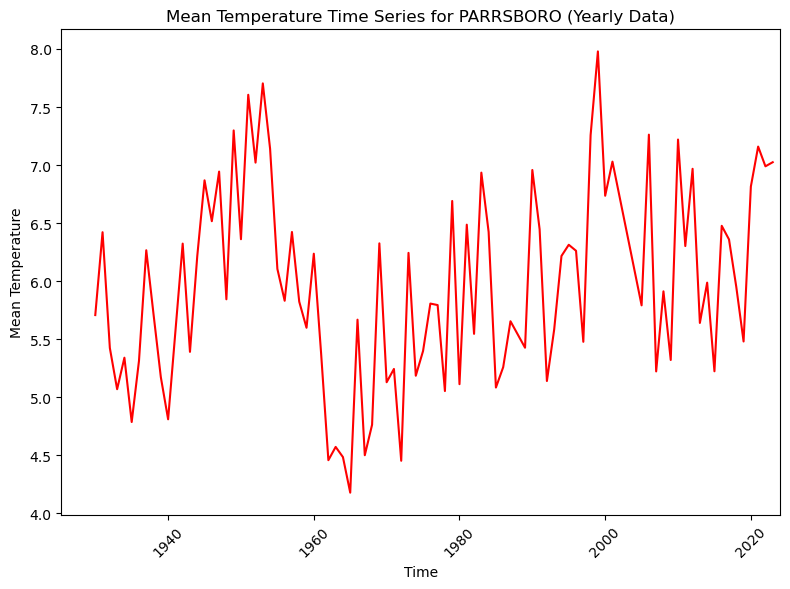

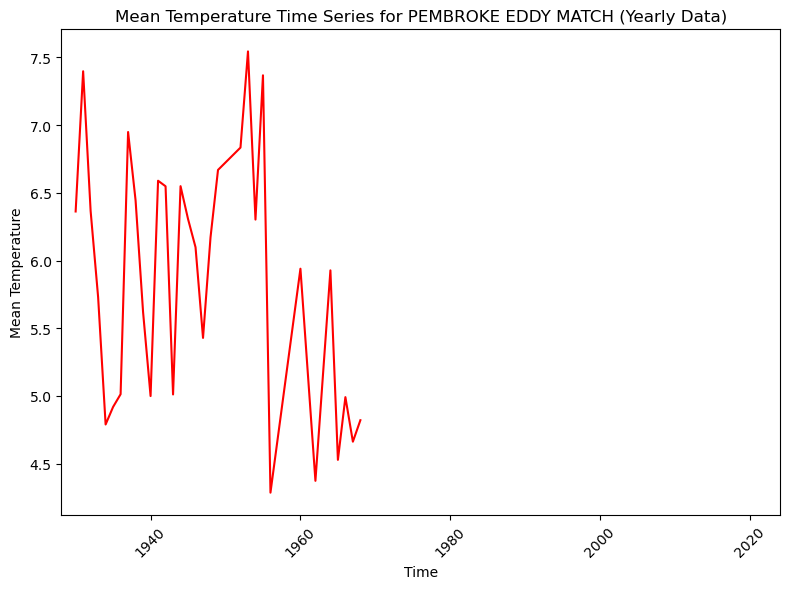

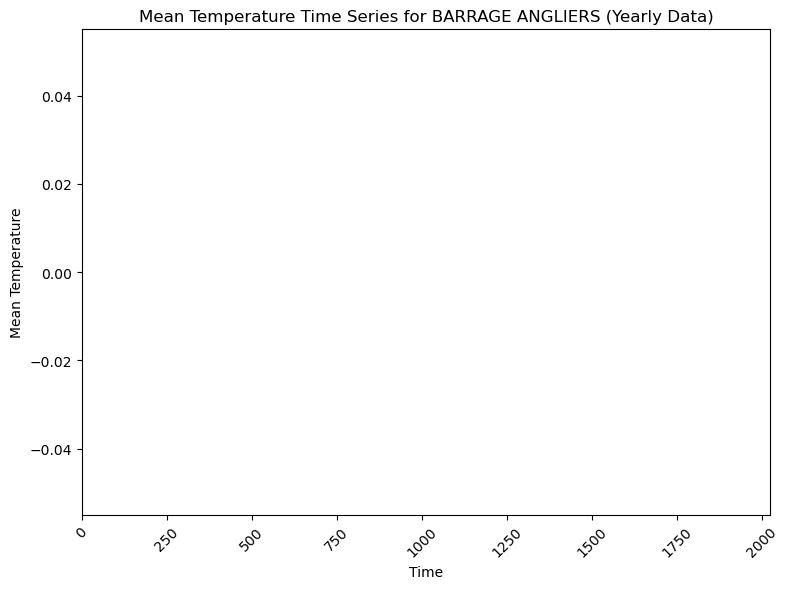

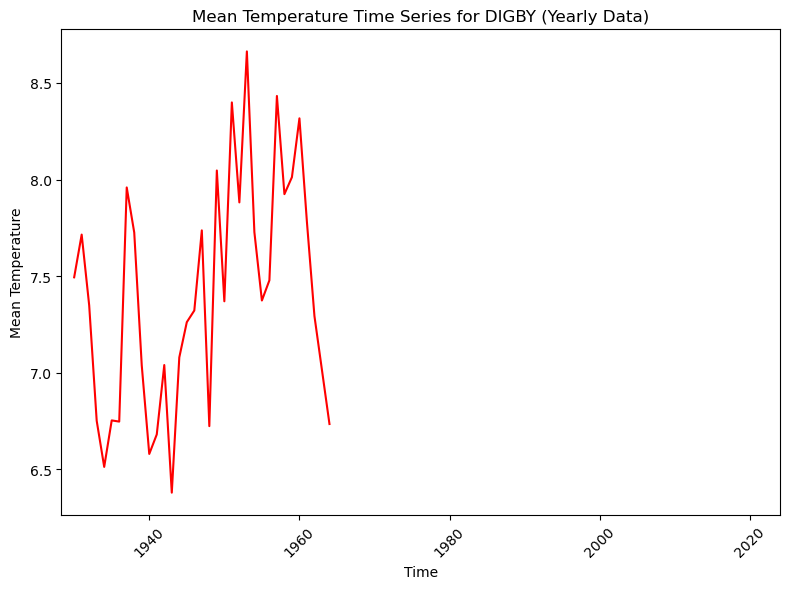

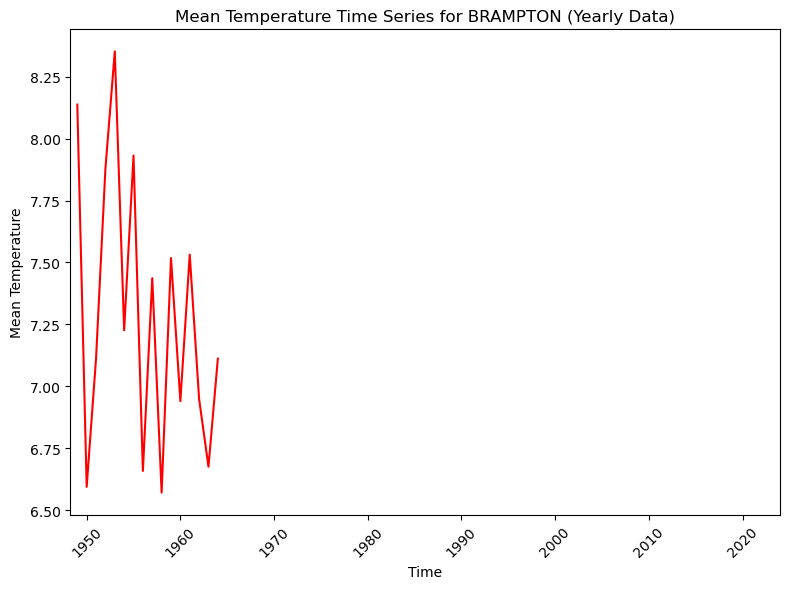

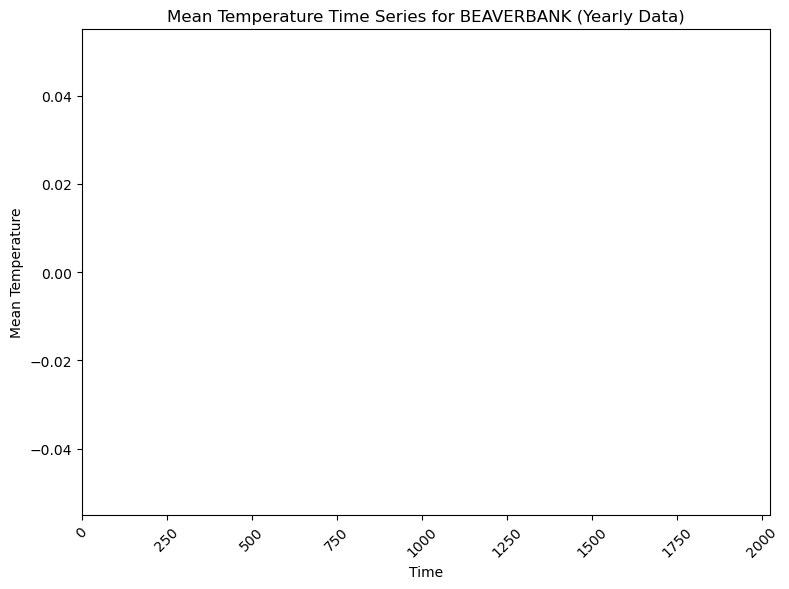

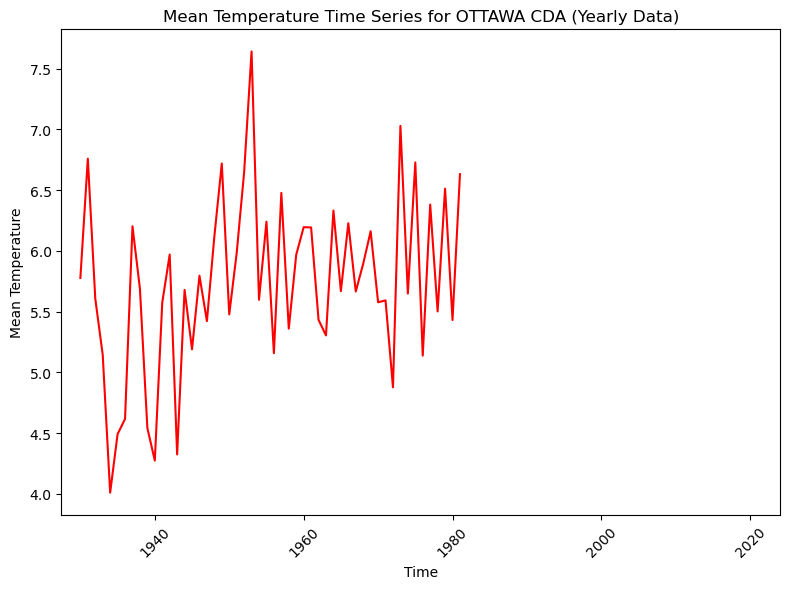

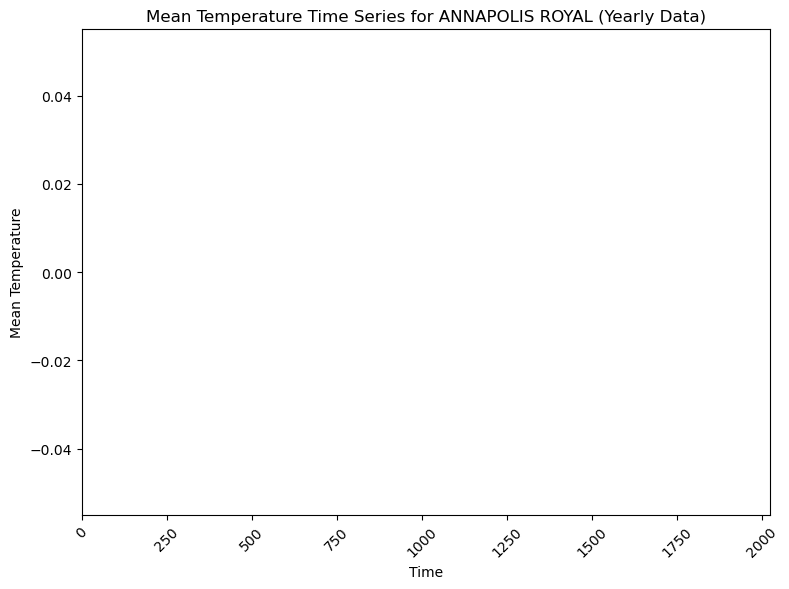

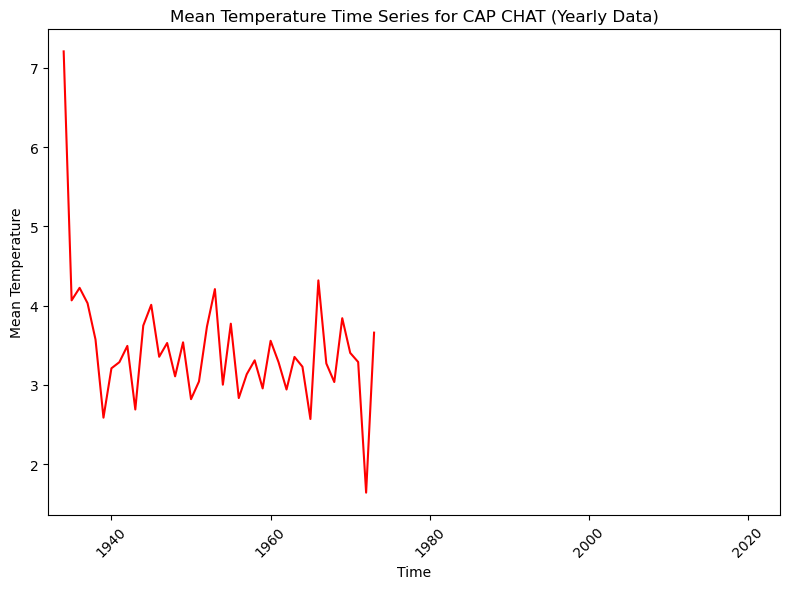

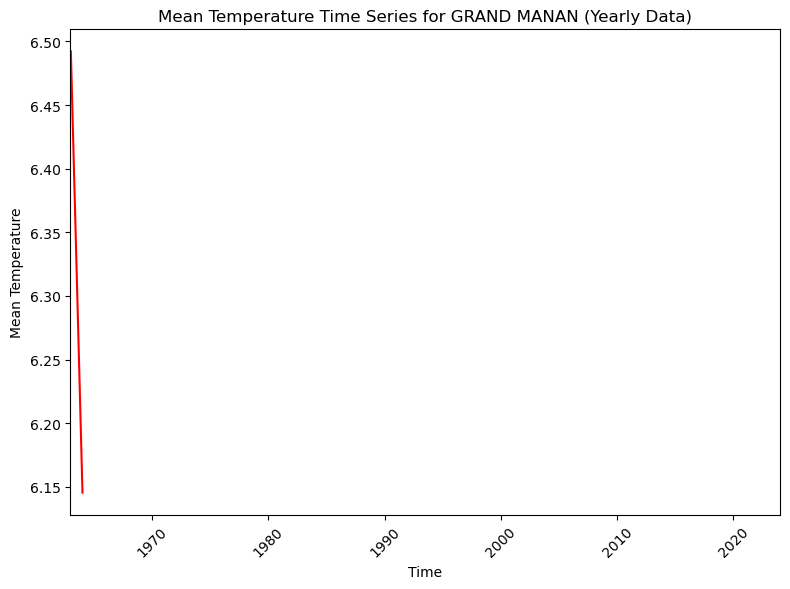

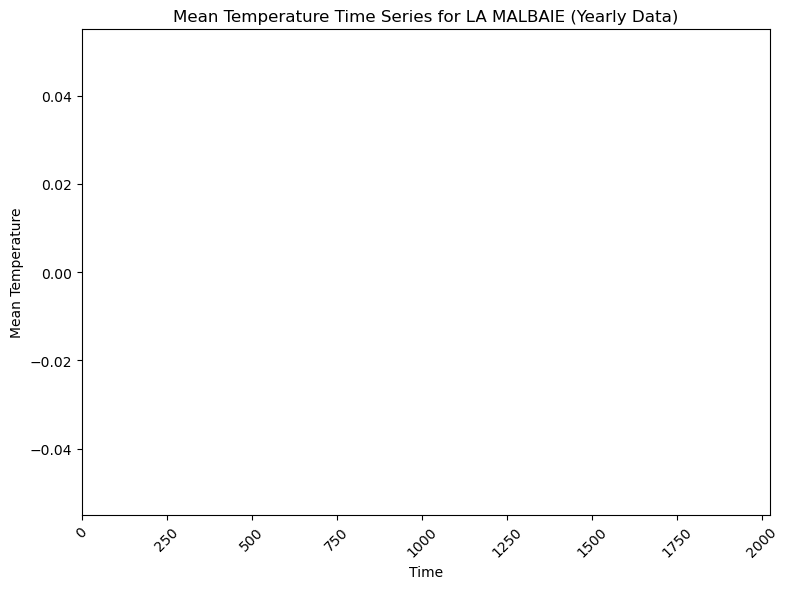

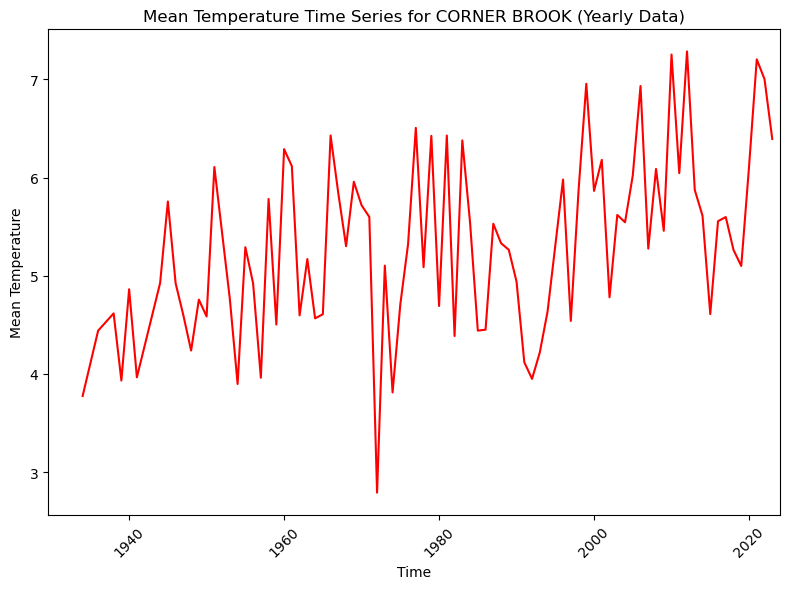

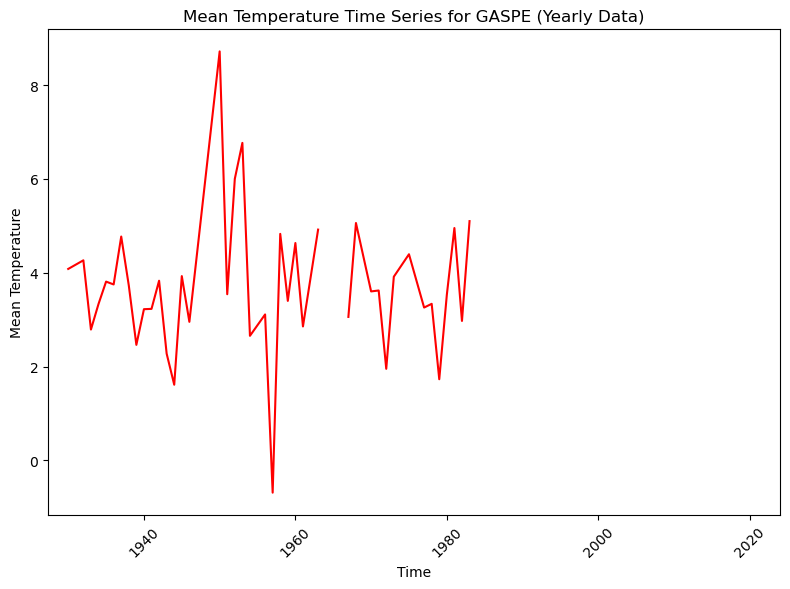

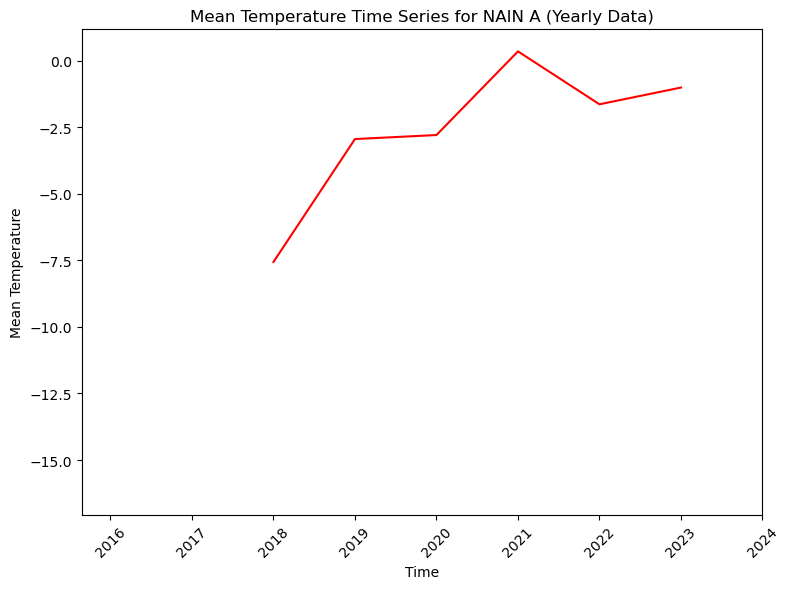

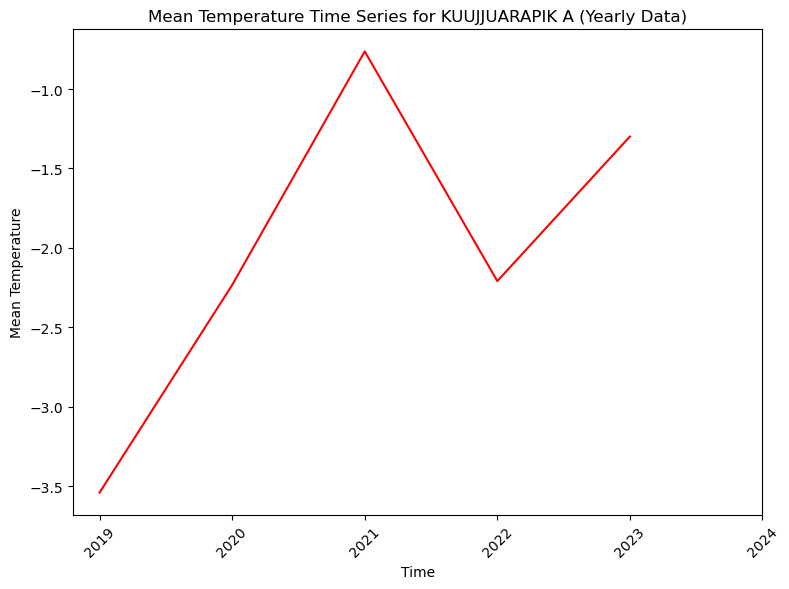

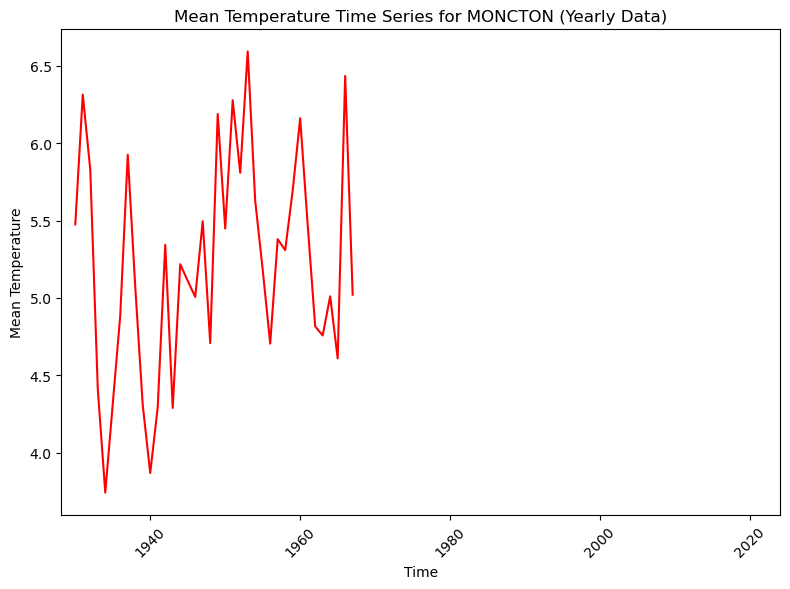

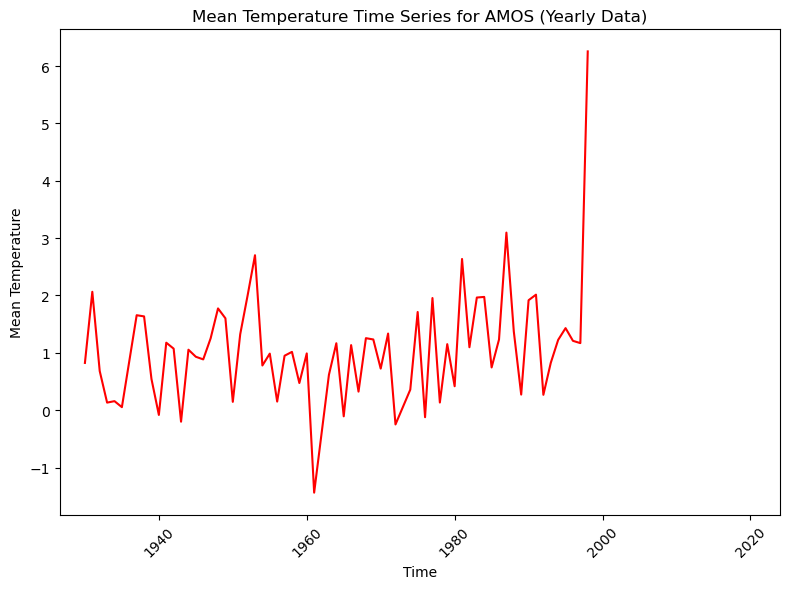

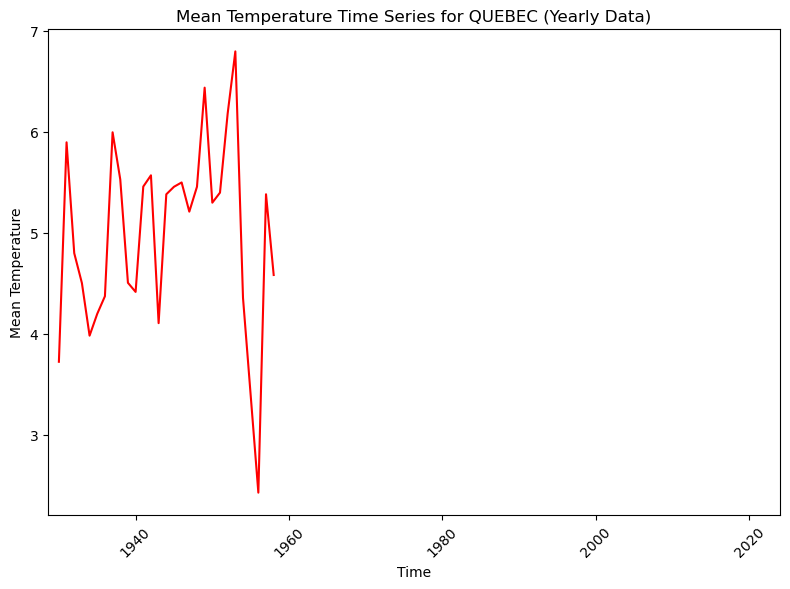

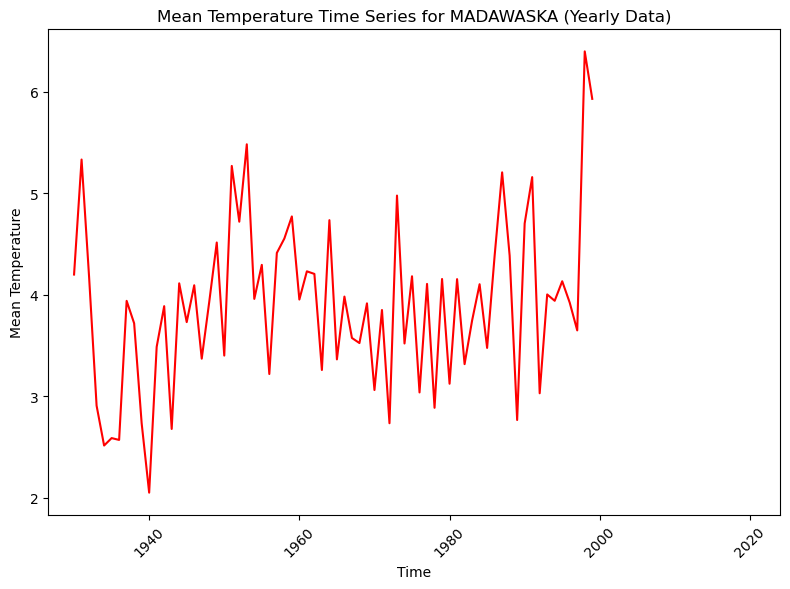

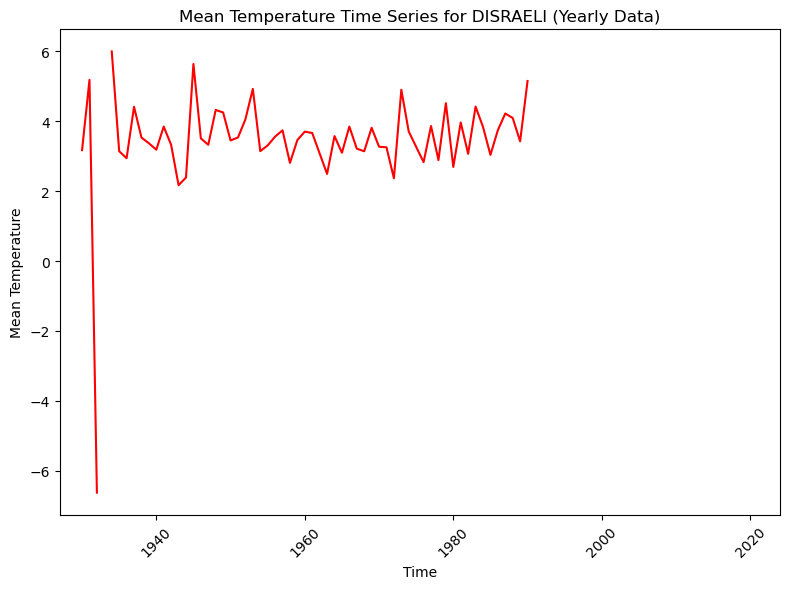

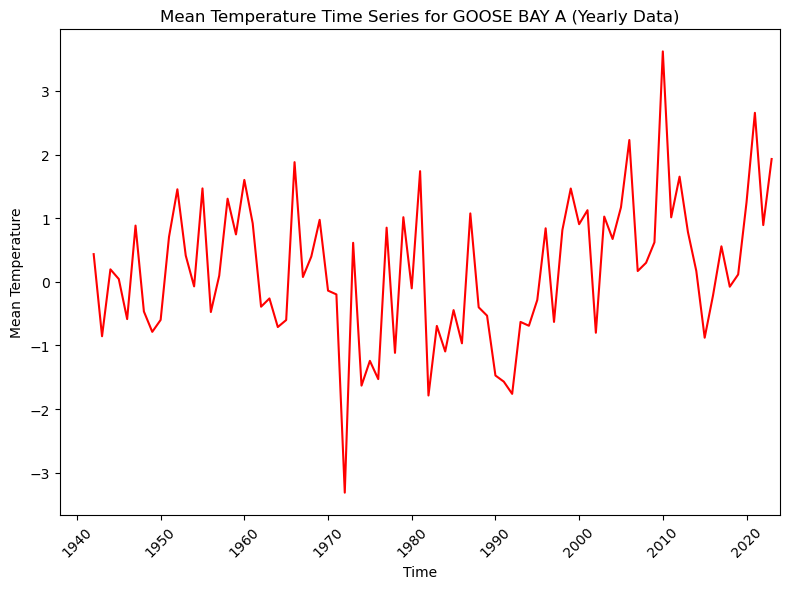

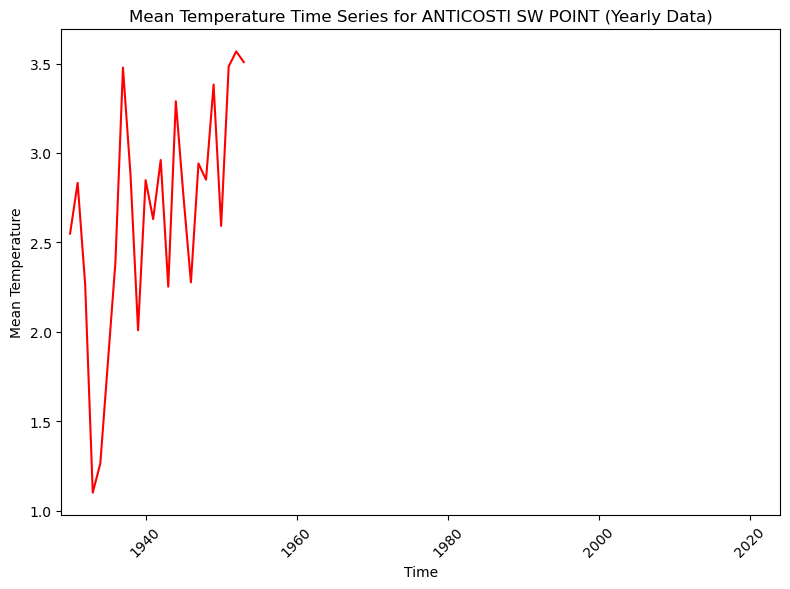

In [105]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_station_time_series(station_name, variable, data_type='yearly'):
    data = pd.read_csv('CanadianStationAverages_Cleaned.csv')
    
    data = data[(data['STATION_NAME'] == station_name) & (data['average_type'] == data_type)]#filter data for sation name and the value
    
    if variable not in data.columns:#check if variable is in dataset
        print(f"Error: '{variable}' is not a column in the dataset.")
        return

    if data_type == 'yearly':#setting time axis based on data type
        data = data.sort_values(by='year')
        time_axis = data['year']
    elif data_type == 'monthly':
        data = data.sort_values(by=['year', 'month'])
        time_axis = pd.to_datetime(data[['year', 'month']].assign(day=1))
    else:
        print("Error: data_type must be either 'yearly' or 'monthly'")
        return

    plt.figure(figsize=(8, 6))#plotting
    plt.plot(time_axis, data[variable], linestyle='-', color='red')
    plt.xlabel('Time')
    plt.ylabel(variable.replace('_', ' ').title())
    plt.title(f"{variable.replace('_', ' ').title()} Time Series for {station_name} ({data_type.capitalize()} Data)")
    plt.grid(False)
    plt.xticks(rotation=45)
    plt.xlim(None, 2024)
    plt.tight_layout()
    plt.show()


plot_station_time_series("PARRSBORO", "MEAN_TEMPERATURE", data_type='yearly')
plot_station_time_series("PEMBROKE EDDY MATCH", "MEAN_TEMPERATURE", data_type='yearly')
plot_station_time_series("BARRAGE ANGLIERS", "MEAN_TEMPERATURE", data_type='yearly')
plot_station_time_series("DIGBY", "MEAN_TEMPERATURE", data_type='yearly')
plot_station_time_series("BRAMPTON", "MEAN_TEMPERATURE", data_type='yearly')
plot_station_time_series("BEAVERBANK", "MEAN_TEMPERATURE", data_type='yearly')
plot_station_time_series("OTTAWA CDA", "MEAN_TEMPERATURE", data_type='yearly')
plot_station_time_series("ANNAPOLIS ROYAL", "MEAN_TEMPERATURE", data_type='yearly')
plot_station_time_series("CAP CHAT", "MEAN_TEMPERATURE", data_type='yearly')
plot_station_time_series("GRAND MANAN", "MEAN_TEMPERATURE", data_type='yearly')
plot_station_time_series("LA MALBAIE", "MEAN_TEMPERATURE", data_type='yearly')
plot_station_time_series("CORNER BROOK", "MEAN_TEMPERATURE", data_type='yearly')
plot_station_time_series("GASPE", "MEAN_TEMPERATURE", data_type='yearly')
plot_station_time_series("NAIN A", "MEAN_TEMPERATURE", data_type='yearly')
plot_station_time_series("KUUJJUARAPIK A", "MEAN_TEMPERATURE", data_type='yearly')
plot_station_time_series("MONCTON", "MEAN_TEMPERATURE", data_type='yearly')
plot_station_time_series("AMOS", "MEAN_TEMPERATURE", data_type='yearly')
plot_station_time_series("QUEBEC", "MEAN_TEMPERATURE", data_type='yearly')
plot_station_time_series("MADAWASKA", "MEAN_TEMPERATURE", data_type='yearly')
plot_station_time_series("DISRAELI", "MEAN_TEMPERATURE", data_type='yearly')
plot_station_time_series("GOOSE BAY A", "MEAN_TEMPERATURE", data_type='yearly')
plot_station_time_series("ANTICOSTI SW POINT", "MEAN_TEMPERATURE", data_type='yearly')



The following outputs a list of the stations in the dataset sorted by number of years of recorded data:

In [61]:
import pandas as pd

data = pd.read_csv('CanadianStationAverages.csv')

data = data.dropna(subset=['year'])#filtering rows where year value is NaN

time_span = data.groupby(['x', 'y', 'STATION_NAME']).agg(#calculates time span for each station
    start_year=('year', 'min'),
    end_year=('year', 'max')
).reset_index()

time_span['years_of_data'] = time_span['end_year'] - time_span['start_year'] + 1 #finds difference between start and end year of records

time_span = time_span.sort_values(by='years_of_data', ascending=False)#sorting by largest

top_stations = time_span[['STATION_NAME', 'years_of_data', 'start_year', 'end_year']]#create sorteed list of stations

print(top_stations)

top_stations.to_csv('TopStationsByTimeSpan.csv', index=False)



         STATION_NAME  years_of_data  start_year  end_year
135        BELLEVILLE            159        1866      2024
238        HUNTINGDON            154        1870      2023
680           BADDECK            127        1874      2000
713  PORT AUX BASQUES            116        1909      2024
544        NAPPAN CDA            116        1890      2005
..                ...            ...         ...       ...
747     26 MILE DEPOT              1        1962      1962
133      LAC NATHALIE              1        1974      1974
139       LAC CARAVAN              1        1973      1973
140        LAC RANDAL              1        1973      1973
473      KEMPTVILLE 2              1        1956      1956

[834 rows x 4 columns]


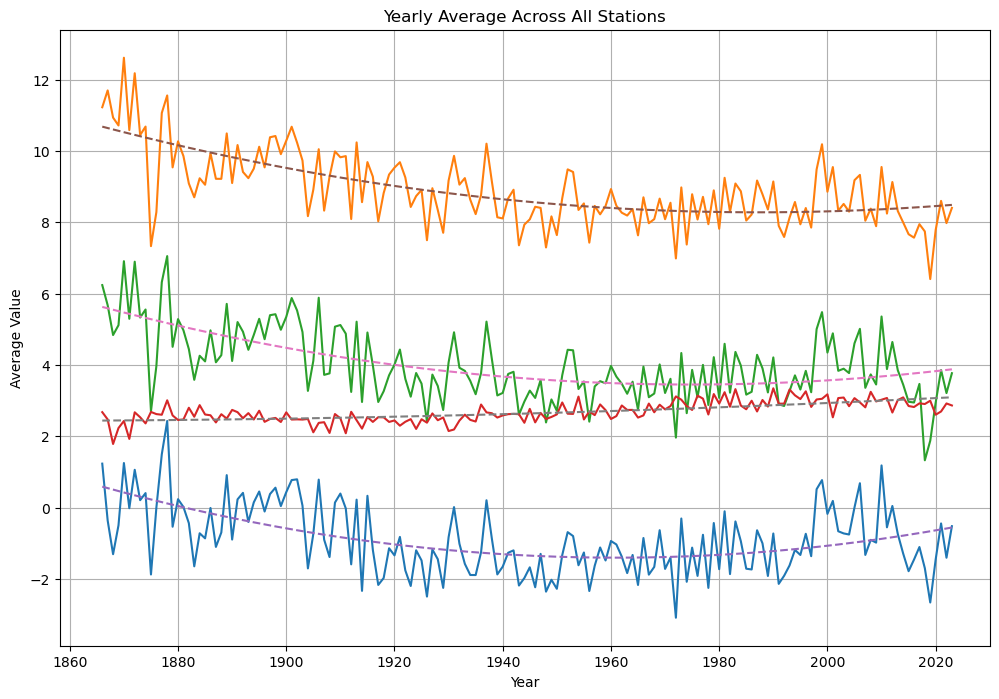

In [115]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

data = pd.read_csv('CanadianStationAverages.csv')

def plot_average_over_all_stations(regression_type=None):

    yearly_data = data[data['average_type'] == 'yearly']#filtering to include only yearly averages
    
    yearly_avg_all_stations = yearly_data.groupby('year').mean(numeric_only=True).reset_index()#group by year and calculate mean for each variable across all stations
    
    plt.figure(figsize=(12, 8))
    plt.plot(yearly_avg_all_stations['year'], yearly_avg_all_stations['MIN_TEMPERATURE'], label='Min Temperature')
    plt.plot(yearly_avg_all_stations['year'], yearly_avg_all_stations['MAX_TEMPERATURE'], label='Max Temperature')
    plt.plot(yearly_avg_all_stations['year'], yearly_avg_all_stations['MEAN_TEMPERATURE'], label='Mean Temperature')
    plt.plot(yearly_avg_all_stations['year'], yearly_avg_all_stations['TOTAL_PRECIPITATION'], label='Total Precipitation')
    
    if regression_type in ['linear', 'quadratic']:#specifies regression used
        for param in ['MIN_TEMPERATURE', 'MAX_TEMPERATURE', 'MEAN_TEMPERATURE', 'TOTAL_PRECIPITATION']:
            if regression_type == 'linear':#fitting regression lines
                coeffs = np.polyfit(yearly_avg_all_stations['year'], yearly_avg_all_stations[param], 1)
            elif regression_type == 'quadratic':
                coeffs = np.polyfit(yearly_avg_all_stations['year'], yearly_avg_all_stations[param], 2)
            regression_values = np.polyval(coeffs, yearly_avg_all_stations['year'])#generates regression values
            plt.plot(yearly_avg_all_stations['year'], regression_values, linestyle='--', label=f'{param} ({regression_type} fit)')#plots regression

    plt.xlabel('Year')
    plt.ylabel('Average Value')
    plt.title('Yearly Average Across All Stations')
    plt.xlim(None, 2030)
    plt.grid(True)
    plt.show()
plot_average_over_all_stations(regression_type='quadratic')

